In [1]:
from enum import Enum
from random import random
import numpy as np

In [2]:
class Action(Enum):
    A = 0
    B = 1


def choose_action():
    if 7 * random() < 1:
        return Action.A
    else:
        return Action.B


In [3]:
for i in range(20):
    print(choose_action().name, end=', ')

B, B, B, B, B, B, B, B, B, A, B, B, B, B, B, B, B, B, B, B, 

In [4]:
class Problem:
    class State(Enum):
        S1 = 0
        S2 = 1
        S3 = 2
        S4 = 3
        S5 = 4
        S6 = 5
        S7 = 6

    STATES = list(State.__members__.values())
    N_STATES = len(STATES)

    def __init__(self):
        self._transition_probs = self.define_transition_probabilities()

    @property
    def transition_probs(self):
        return self._transition_probs

    @property
    def transition_probs_a(self):
        return self._transition_probs[Action.A.value]

    @property
    def transition_probs_b(self):
        return self._transition_probs[Action.B.value]

    @classmethod
    def define_transition_probabilities(cls):
        tp_a = np.zeros((cls.N_STATES, cls.N_STATES))
        tp_a[:, -1] = 1

        tp_b = np.full((cls.N_STATES, cls.N_STATES), 1/6)
        tp_b[:, -1] = 0

        return np.stack([tp_a, tp_b])

    def take_action(self, state: State, action: Action) -> State:
        target_probs = self.transition_probs[action.value, state.value]
        return np.random.choice(self.STATES, p=target_probs)



In [5]:
p = Problem()
p.transition_probs.shape

(2, 7, 7)

In [6]:
p.transition_probs_a


array([[0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.]])

In [7]:
p.transition_probs_b

array([[0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.        ],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.        ],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.        ],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.        ],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.        ],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.        ],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.        ]])

In [8]:
for i in range(10):
    print(p.take_action(p.State.S1, Action.A).name, end=", ")

S7, S7, S7, S7, S7, S7, S7, S7, S7, S7, 

In [9]:
for i in range(10):
    print(p.take_action(p.State.S1, Action.B).name, end=", ")

S4, S4, S2, S5, S1, S2, S2, S6, S5, S2, 

In [10]:
p.transition_probs[0, 1]

array([0., 0., 0., 0., 0., 0., 1.])

In [11]:
np.random.choice(p.STATES, p=p.transition_probs[0, 1])

<State.S7: 6>

In [47]:
from abc import ABC, abstractmethod


class Algorithm(ABC):
    def __init__(self, problem: Problem, n_params: int, alpha=0.01, gamma=0.99, reward=0):
        self.problem = problem
        self.phi = self.define_weight_matrices(problem.N_STATES, n_params)

        self.alpha = alpha
        self.gamma = gamma
        self.reward = reward

    @staticmethod
    def define_weight_matrices(n_states: int, n_params: int):
        phi_a = np.zeros((n_states, n_params), dtype=int)
        phi_a[:, n_params//2] = 1
        phi_a[np.arange(n_states-1), np.arange(n_states-1)] = 2
        phi_a[n_states-1, n_states-1] = 1
        phi_a[n_states-1, n_states] = 2

        phi_b = np.zeros((n_states, n_params), dtype=int)
        phi_b[np.arange(n_states), n_params//2 + n_params%2 + np.arange(n_states)] = 1

        return np.stack([phi_a, phi_b]).swapaxes(0, 1)

    @abstractmethod
    def run(self, w_init, n_steps: int):
        pass


class Sarsa(Algorithm):
    def run(self, w_init, n_steps: int):
        w = w_init[:].astype(float)
        state = np.random.choice(p.STATES)
        action = choose_action()
        states_sequence = [state]
        actions_sequence = []
        w_norms = [np.linalg.norm(w)]

        for _ in range(20):
            actions_sequence.append(action)

            new_state = p.take_action(state, action)
            new_action = choose_action()

            phi_st = self.phi[state.value, action.value]
            phi_new_st = self.phi[new_state.value, new_action.value]
            estimate = phi_st @ w
            target = self.reward + self.gamma * phi_new_st @ w
            w += self.alpha * phi_st * (target - estimate)

            state = new_state
            action = new_action
            states_sequence.append(state)
            w_norms.append(np.linalg.norm(w))

        return w_norms, states_sequence, actions_sequence

In [48]:
sarsa = Sarsa(p, 15)
sarsa.phi.shape

(7, 2, 15)

In [49]:
sarsa.phi[:, 0]

array([[2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0]])

In [50]:
sarsa.phi[:, 1]

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [53]:
w_init = np.array(6*[1] + [10] + 8 * [1])
w_init

array([ 1,  1,  1,  1,  1,  1, 10,  1,  1,  1,  1,  1,  1,  1,  1])

In [54]:
sarsa.phi @ w_init

array([[ 3,  1],
       [ 3,  1],
       [ 3,  1],
       [ 3,  1],
       [ 3,  1],
       [ 3,  1],
       [12,  1]])

In [55]:
sarsa_w_norms, sarsa_states, sarsa_actions = sarsa.run(w_init=w_init, n_steps=20)
for s, a in zip(sarsa_states, sarsa_actions):
    print(f"{s.name}, {a.name}, ", end='')
print(sarsa_states[-1].name)

S6, B, S6, B, S6, B, S6, B, S4, B, S3, B, S4, B, S1, B, S1, A, S7, A, S7, B, S2, A, S7, B, S1, B, S3, B, S1, B, S2, B, S6, B, S3, B, S2, B, S5


In [57]:
np.array(sarsa_w_norms)

array([10.67707825, 10.67706889, 10.67705952, 10.67705016, 10.67704108,
       10.67703171, 10.67702226, 10.67701299, 10.67887608, 10.70563504,
       10.580569  , 10.58232043, 10.57737346, 10.57736493, 10.5773362 ,
       10.577345  , 10.57731667, 10.57730685, 10.57729776, 10.57728822,
       10.57727887])

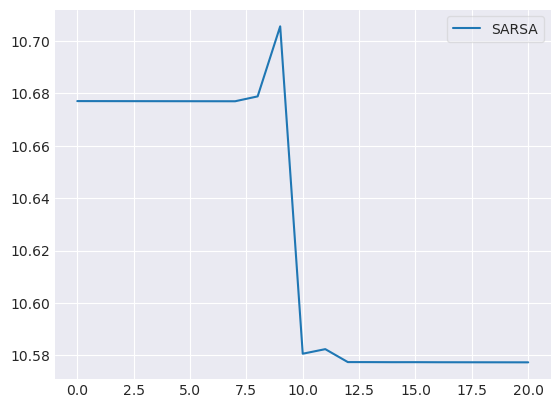

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt

with plt.style.context('seaborn-v0_8-darkgrid'):
    fig, ax = plt.subplots()
    ax.plot(np.arange(len(sarsa_w_norms)), np.array(sarsa_w_norms), label='SARSA')

    ax.legend(frameon=True, fancybox=True, framealpha=0.5)